## 1. Import Libraries

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import cv2
import os
import base64
import requests
from dotenv import load_dotenv

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from PIL import Image


## 2. Import Model and Images

### 2.1 Import Model

In [3]:

model = load_model('../../Models/segmentation_model.h5')

2024-08-21 18:50:39.648914: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2024-08-21 18:50:39.648937: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-08-21 18:50:39.648941: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-08-21 18:50:39.648956: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-21 18:50:39.648967: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### 2.2 Import Images

In [6]:
# Load and preprocess the image
#img_path = 'Resources/images/img_0001.png'
img_path = '../Resources/test_Images/test_image_001.png'  # Replace with the actual path to your image
#img_path = 'Resources/test_Images/test_image_001.png'
img = load_img(img_path, target_size=(384,384))  # Replace height and width with your model's input size
img_array_org = img_to_array(img)
img_array = np.expand_dims(img_array_org, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize the image if required by your model

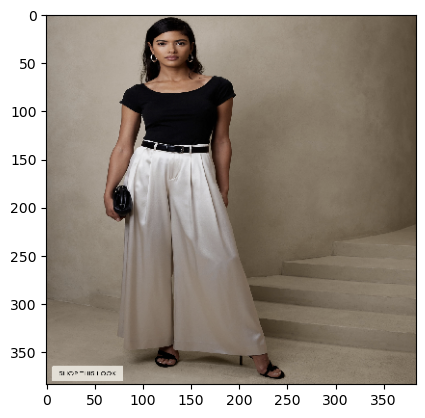

In [7]:
# Display image
plt.imshow(img)

## 3. Make Predictions

In [8]:
# Predict image mask
predicted_mask = model.predict(img_array)

2024-08-21 18:50:58.927391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [9]:
# Get image mask shape
predicted_mask.shape

(1, 384, 384, 59)

In [10]:
# Use the squeeze fuction to change the image mask shape
predicted_mask = np.squeeze(predicted_mask, axis=0)
predicted_mask.shape

(384, 384, 59)

In [11]:
predicted_mask = np.argmax(predicted_mask, axis=-1)
predicted_mask.shape

(384, 384)

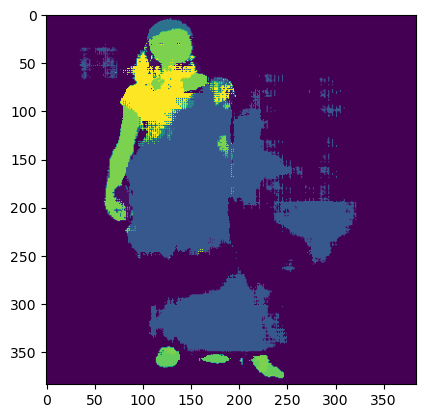

In [12]:
# Display the predicted mask
plt.imshow(predicted_mask, cmap='viridis')  # Use 'viridis' or another colormap for multi-class
plt.show()

In [13]:
# Precicted classes
print(*np.unique(predicted_mask).tolist(),sep=', ')


0, 1, 2, 4, 5, 10, 14, 19, 26, 39, 41, 42, 48, 49, 51


## 4. Get Bounding Boxes of classes

In [14]:
# Create a function to get the bounding boxes
def get_class_bounding_boxes(mask, num_classes):
    """
    Find bounding boxes for each class in the segmentation mask.
    
    Args:
    mask: np.array, shape (height, width), contains class labels for each pixel.
    num_classes: int, number of classes.
    
    Returns:
    bounding_boxes: dict, where keys are class indices and values are bounding boxes (x_min, y_min, x_max, y_max).
    """
    bounding_boxes = {}
    
    for class_idx in range(num_classes):
        # Find all pixels belonging to the current class
        class_mask = (mask == class_idx).astype(np.uint8)

        # Find contours for the class mask
        contours, _ = cv2.findContours(class_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if contours:
            # Find the bounding box around the largest contour
            x_min, y_min, x_max, y_max = np.inf, np.inf, -np.inf, -np.inf
            for contour in contours:
                x, y, w, h = cv2.boundingRect(contour)
                x_min, y_min = min(x_min, x), min(y_min, y)
                x_max, y_max = max(x_max, x + w), max(y_max, y + h)
            
            bounding_boxes[class_idx] = (x_min, y_min, x_max, y_max)

    return bounding_boxes

In [15]:
num_classes = predicted_mask.max() + 1  
bounding_boxes = get_class_bounding_boxes(predicted_mask, num_classes)

# bounding_boxes will now contain the bounding box for each class
for class_idx, box in bounding_boxes.items():
    print(f"Class {class_idx}: Bounding Box {box}")

Class 0: Bounding Box (0, 0, 384, 384)
Class 1: Bounding Box (71, 30, 161, 205)
Class 2: Bounding Box (60, 23, 196, 354)
Class 4: Bounding Box (112, 61, 113, 62)
Class 5: Bounding Box (105, 55, 130, 78)
Class 10: Bounding Box (187, 350, 192, 351)
Class 14: Bounding Box (35, 31, 322, 354)
Class 19: Bounding Box (105, 4, 153, 27)
Class 26: Bounding Box (80, 56, 189, 123)
Class 39: Bounding Box (114, 348, 247, 378)
Class 41: Bounding Box (60, 15, 238, 376)
Class 42: Bounding Box (64, 100, 195, 227)
Class 48: Bounding Box (128, 89, 163, 253)
Class 49: Bounding Box (126, 120, 131, 131)
Class 51: Bounding Box (72, 30, 197, 253)


In [16]:
def expand_bounding_box(x_min, y_min, x_max, y_max, dx, dy, image_width, image_height):
    new_x_min = max(0, x_min - dx)
    new_y_min = max(0, y_min - dy)
    new_x_max = min(image_width, x_max + dx)
    new_y_max = min(image_height, y_max + dy)
    return new_x_min, new_y_min, new_x_max, new_y_max

In [17]:
new_bounding_boxes = {}
# Expand bounding_boxes
for class_idx,box in bounding_boxes.items():
    x_min, y_min, x_max, y_max = box
    dx, dy = 10, 10  # Change this to the desired expansion
    new_box = expand_bounding_box(x_min, y_min, x_max, y_max, dx, dy, 
                              predicted_mask.shape[1], predicted_mask.shape[0])
    new_bounding_boxes[class_idx] = new_box
    print(f"Expanded Box: {new_box}")

bounding_boxes = new_bounding_boxes
    


Expanded Box: (0, 0, 384, 384)
Expanded Box: (61, 20, 171, 215)
Expanded Box: (50, 13, 206, 364)
Expanded Box: (102, 51, 123, 72)
Expanded Box: (95, 45, 140, 88)
Expanded Box: (177, 340, 202, 361)
Expanded Box: (25, 21, 332, 364)
Expanded Box: (95, 0, 163, 37)
Expanded Box: (70, 46, 199, 133)
Expanded Box: (104, 338, 257, 384)
Expanded Box: (50, 5, 248, 384)
Expanded Box: (54, 90, 205, 237)
Expanded Box: (118, 79, 173, 263)
Expanded Box: (116, 110, 141, 141)
Expanded Box: (62, 20, 207, 263)


### 5. Get Labels from Classes

In [18]:
# Import labels from csv file
labels = pd.read_csv('../Resources/labels/labels.csv')
# Drop unamed column
labels.drop('Unnamed: 0', axis=1, inplace=True)
# Display labels
labels.head()


,label_list,category
0,NaN,other
1,accessories,other
2,bag,other
3,belt,other
4,blazer,upper


In [19]:
labels['category'].unique()

array(['other', 'upper', 'shoes', 'head', 'lower'], dtype=object)

In [20]:
# Get label names from bounding_boxes keys
image_labels = labels.iloc[list(bounding_boxes.keys())].reset_index(drop=True)
image_labels

,label_list,category
0,NaN,other
1,accessories,other
2,bag,other
3,blazer,upper
4,blouse,upper
5,cape,upper
6,dress,upper
7,hair,other
8,jumper,upper
9,shoes,shoes


### 6. Create images from the bounding boxes

In [21]:
images=[]
pixels = []
# Loop through bounding boxes, crop images and save them to disk
for class_idx, box in bounding_boxes.items():
    class_name = labels.iloc[class_idx]['label_list']
    temp_img = img.crop(box)
    images.append(temp_img)
    pixels.append(temp_img.size[0]*temp_img.size[1])

In [22]:
image_labels['pixels'] = pixels
image_labels = image_labels.sort_values(by='pixels', ascending=False)
image_labels

,label_list,category,pixels
0,NaN,other,147456
6,dress,upper,105301
10,skin,other,75042
2,bag,other,54756
14,t-shirt,upper,35235
11,skirt,lower,22197
1,accessories,other,21450
8,jumper,upper,11223
12,sweater,upper,10120
9,shoes,shoes,7038


In [23]:
def get_middle_index(df):
    if len(df)%2 == 0:
        return int(len(df)/2)-1
    else:
        return int((len(df) - 1)/2)

In [24]:
bounding_categories = ['upper', 'lower', 'shoes']
bounding_images = []

In [25]:
for category in bounding_categories:
    # Filter labels based on the category
    #filtered_labels = image_labels[(image_labels['category'] == category) & (image_labels['pixels'] > 3000)]
    filtered_labels = image_labels[(image_labels['category'] == category)]
    
    # If labels exist for the category
    if len(filtered_labels) >= 1:
        # Set label as the middle index
        #filtered_labels = filtered_labels.iloc[get_middle_index(filtered_labels)]
        filtered_labels = filtered_labels.iloc[0]
        print(filtered_labels)
        # Save a copy of the image
        images[filtered_labels.name].save(f'../Output/images/{category}.png')
        # Add image to list
        bounding_images.append(images[filtered_labels.name])
    else:
        Image.new('RGB', (10, 10)).save(f'../Output/images/{category}.png')

label_list     dress
category       upper
pixels        105301
Name: 6, dtype: object
label_list    skirt
category      lower
pixels        22197
Name: 11, dtype: object
label_list    shoes
category      shoes
pixels         7038
Name: 9, dtype: object


In [26]:
bounding_images

[<PIL.Image.Image image mode=RGB size=307x343>,
 <PIL.Image.Image image mode=RGB size=151x147>,
 <PIL.Image.Image image mode=RGB size=153x46>]

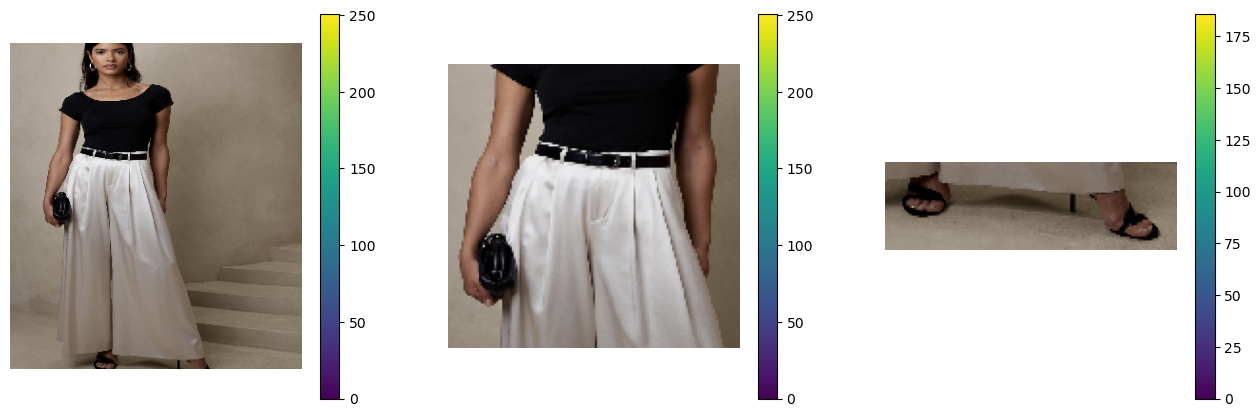

None


In [27]:
plt.figure(figsize=(16,5))
for i in range(len(bounding_images)):
    plt.subplot(1,3,i+1)
    img = bounding_images[i]
    plt.imshow(img)
    plt.colorbar()
    plt.axis('off')
print(plt.show())

In [28]:
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

In [29]:
def image_to_text(image_path, category):
    # Load OpenAI api key
    load_dotenv() 
    api_key = os.getenv("OPENAI_API_KEY")
    # Getting the base64 string
    base64_image = encode_image(image_path)
    # Header
    headers = {
      "Content-Type": "application/json",
      "Authorization": f"Bearer {api_key}"
    }
    # Payload
    payload = {
      "model": "gpt-4o-mini",
      "messages": [
        { 
          "role": "user",
          "content": [
            {
              "type": "text",
              "text": f"{category} clothing color, type, length, fit, style. Message should only include these two details"
            },
            {
              "type": "image_url",
              "image_url": {
                "url": f"data:image/jpeg;base64,{base64_image}"
              }
            }
          ]
        }
      ],
      "max_tokens": 300
    }
    # Response
    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)

    return response.json()['choices'][0]['message']['content'].replace('\n',', ')
    

In [30]:
texts=[]
for category in bounding_categories:
      # Create image path
      image_path = f"../Output/images/{category}.png"
      # Rund the iamge to text function with OpenAI
      texts.append(image_to_text(image_path, category))

In [31]:
for text in texts:
    print(text)

- Color: Black  , - Type: Off-shoulder top  
Color: White  , Type: Trousers  , Length: Full length  , Fit: Loose  , Style: Pleated  
- **Color:** Black  , - **Type:** High-heeled sandals


In [32]:
from serpapi import GoogleSearch

def get_recommendations(item):
    # Load environment variables and API key
    load_dotenv()   
    # Create query for search
    query = f"Shop for Women's sustainable {item}"
    # Search google shopping
    search = GoogleSearch({
        "q": query, 
        "api_key": os.getenv("GOOGLE_SEARCH_API_KEY"),
        "tbm": "shop",  # shop
        #"tbs": "p_ord:rv",
        "num": 100
        })
    # Convert results into a dataframe
    recommendations = pd.DataFrame(search.get_dict()['shopping_results'])

    #recommendations_df.to_csv('search_results/search_results.csv')

    return recommendations

In [33]:
recommendations =[]
for text in texts:
       recommendation = get_recommendations(text)
       recommendation = recommendation[(recommendation['rating'] > 4) & (recommendation['reviews'] > 10)].reset_index(drop=True)
       # Append to list
       recommendations.append(recommendation)

In [34]:
recommendations[1].head()

,position,title,product_link,product_id,serpapi_product_api,source,price,extracted_price,extensions,thumbnail,delivery,old_price,extracted_old_price,tag,rating,reviews,number_of_comparisons
0,12,Calia Women's Truelight Wide Leg Pant,https://www.google.com/shopping/product/141253...,14125304646313513631,https://serpapi.com/search.json?device=desktop...,DICK'S Sporting Goods,$26.97,26.97,"[Free 90-day returns, 65% OFF]",https://encrypted-tbn2.gstatic.com/shopping?q=...,NaN,$78,78.0,65% OFF,4.4,91.0,2+
1,14,LILYSILK Women's Timeless Pleated Wide-Leg Den...,https://www.google.com/shopping/product/821004...,8210045891087903313,https://serpapi.com/search.json?device=desktop...,LilySilk,$239.20,239.20,"[Free 30-day returns, 20% OFF]",https://encrypted-tbn0.gstatic.com/shopping?q=...,Free by 9/3,$299,299.0,20% OFF,4.5,21.0,NaN
2,15,Cotton On Women's Haven Wide Leg Pants,https://www.google.com/shopping/product/139867...,13986719818109602574,https://serpapi.com/search.json?device=desktop...,Cotton On,$49.99,49.99,[Lifetime returns],https://encrypted-tbn3.gstatic.com/shopping?q=...,NaN,NaN,NaN,NaN,4.2,305.0,NaN
3,16,Women's Wide-Leg Pleated Trouser,https://www.google.com/shopping/product/225440...,2254406309451225479,https://serpapi.com/search.json?device=desktop...,Banana Republic Factory,$64.97,64.97,"[Free 30-day returns, 35% OFF]",https://encrypted-tbn1.gstatic.com/shopping?q=...,NaN,$100,100.0,35% OFF,4.3,49.0,NaN
4,30,Klassy Network Wide Leg Trousers,https://www.google.com/shopping/product/144046...,14404663646171327851,https://serpapi.com/search.json?device=desktop...,Klassy Network,$69.00,69.00,[14-day returns],https://encrypted-tbn1.gstatic.com/shopping?q=...,Free $99+,NaN,NaN,NaN,4.2,55.0,NaN


In [35]:
for recommendation in recommendations:
        # List of pictures to be displayed
        pictures=[]
        print('This is the dataframe')
        print(recommendation)
        # Loop through the recommendations
        for i in range(len(recommendation)):
          print(i)
          # url of the picture
          pic_url = recommendation['thumbnail'][i]
          # Save picture to list
          pictures.append(Image.open(requests.get(pic_url, stream=True).raw))

        # Create three columns
        #col1, col2, col3 = st.columns(3)
        # Loop through the search results
        for i in range(len(recommendation)):
            # Get the image
            image = pictures[i]
            # Column 1
            if i%3 == 0:
                 print('col1')
                #col1.image(image)
                #col1.write(f'[{recommendation['title'][i]}]({recommendation['link'][i]})')
                #col1.write(recommendation['price'][i])
            # Column 2
            elif i%3 == 1:
                 print('col2')
                #col2.image(image)
                #col2.write(f'[{recommendation['title'][i]}]({recommendation['link'][i]})')
                #col2.write(recommendation['price'][i])
            # Column 3
            else:
                 print('col3')
                #col3.image(image)
                #col3.write(f'[{recommendation['title'][i]}]({recommendation['link'][i]})')
                #col3.write(recommendation['price'][i])


This is the dataframe
   position                                              title  \
0        16        Edikted Corey Off-the-Shoulder Gathered Top   
1        18  OGLmove Women's Elegant Sexy Eco- Mousse Solid...   
2        26         Tuckernuck Miranda Off The Shoulder Blouse   
3        33              Edikted Women's Jess Off Shoulder Top   

                                        product_link            product_id  \
0  https://www.google.com/shopping/product/165016...  16501611700336360319   
1  https://www.google.com/shopping/product/125941...    125941470171453397   
2  https://www.google.com/shopping/product/966450...   9664500498417819204   
3  https://www.google.com/shopping/product/496991...    496991082907399238   

                                 serpapi_product_api number_of_comparisons  \
0  https://serpapi.com/search.json?device=desktop...                    2+   
1  https://serpapi.com/search.json?device=desktop...                   NaN   
2  https://serpapi.com

In [36]:
recommendation

,position,title,product_link,product_id,serpapi_product_api,source,price,extracted_price,rating,reviews,extensions,thumbnail,delivery,old_price,extracted_old_price,tag,badge
0,1,Eileen Fisher Women's Fave Sandals,https://www.google.com/shopping/product/168987...,1689871265381539750,https://serpapi.com/search.json?device=desktop...,Dillard's,$175.00,175.00,4.9,12.0,[30-day returns],https://encrypted-tbn1.gstatic.com/shopping?q=...,Free by 8/27,NaN,NaN,NaN,NaN
1,5,Wild Pair Womens Eross Slip On Strappy Heels,https://www.google.com/shopping/product/146171...,14617106855450780747,https://serpapi.com/search.json?device=desktop...,Macy's,$59.50,59.50,4.7,45.0,[Free 30-day returns],https://encrypted-tbn2.gstatic.com/shopping?q=...,Free by 9/4,NaN,NaN,NaN,NaN
2,6,LifeStride Yaya Women's Sandals,https://www.google.com/shopping/product/498216...,4982164145599958862,https://serpapi.com/search.json?device=desktop...,Lifestride.com,$34.99,34.99,4.4,261.0,"[Free 45-day returns, 50% OFF]",https://encrypted-tbn0.gstatic.com/shopping?q=...,Free by 9/3,$70,70.0,50% OFF,NaN
3,7,Toms Womens Ava High Heel Sandal,https://www.google.com/shopping/product/342972...,3429725430663248507,https://serpapi.com/search.json?device=desktop...,TOMS.com,$89.97,89.97,4.6,80.0,"[Free 30-day returns, 18% OFF]",https://encrypted-tbn0.gstatic.com/shopping?q=...,Free delivery,$110,110.0,18% OFF,NaN
4,12,Vionic Chardonnay Women's,https://www.google.com/shopping/product/963101...,9631011263563598456,https://serpapi.com/search.json?device=desktop...,Vionic Shoes,$140.00,140.00,4.4,317.0,"[Free 30-day returns, 360]",https://encrypted-tbn1.gstatic.com/shopping?q=...,NaN,NaN,NaN,360,NaN
5,17,Ninety Union Women's Vegas Dress Sandals,https://www.google.com/shopping/product/642143...,6421431367143213998,https://serpapi.com/search.json?device=desktop...,DSW,$79.99,79.99,4.5,45.0,[90-day returns],https://encrypted-tbn0.gstatic.com/shopping?q=...,Free by 9/3,NaN,NaN,NaN,NaN
6,19,Margaux The City Sandal,https://www.google.com/shopping/product/425546...,4255463712350596585,https://serpapi.com/search.json?device=desktop...,Margaux,$345.00,345.00,4.4,79.0,[30-day returns],https://encrypted-tbn1.gstatic.com/shopping?q=...,Free by 9/4,NaN,NaN,NaN,NaN
7,25,Steve Madden Women's Lessa,https://www.google.com/shopping/product/195351...,1953519788285432621,https://serpapi.com/search.json?device=desktop...,Steve Madden,$109.95,109.95,4.2,240.0,[30-day returns],https://encrypted-tbn1.gstatic.com/shopping?q=...,Free by 9/4,NaN,NaN,NaN,NaN
8,26,Sam Edelman Women's Yaro,https://www.google.com/shopping/product/100165...,10016570038567242200,https://serpapi.com/search.json?device=desktop...,Sam Edelman,$49.99,49.99,4.1,212.0,"[Free 30-day returns, 50% OFF]",https://encrypted-tbn3.gstatic.com/shopping?q=...,Free by 9/3,$100,100.0,50% OFF,NaN
9,30,Women's Naturalizer Brenta Sandal,https://www.google.com/shopping/product/105018...,10501825438599059030,https://serpapi.com/search.json?device=desktop...,Amazon.com,$59.99,59.99,4.6,554.0,"[30-day returns, 360]",https://encrypted-tbn0.gstatic.com/shopping?q=...,Free delivery,NaN,NaN,360,NaN


In [37]:
# Add price column
recommendation['float_price'] = recommendation['price'].apply(lambda x: float(x.replace('$','')))
recommendation.head()

,position,title,product_link,product_id,serpapi_product_api,source,price,extracted_price,rating,reviews,extensions,thumbnail,delivery,old_price,extracted_old_price,tag,badge,float_price
0,1,Eileen Fisher Women's Fave Sandals,https://www.google.com/shopping/product/168987...,1689871265381539750,https://serpapi.com/search.json?device=desktop...,Dillard's,$175.00,175.00,4.9,12.0,[30-day returns],https://encrypted-tbn1.gstatic.com/shopping?q=...,Free by 8/27,NaN,NaN,NaN,NaN,175.00
1,5,Wild Pair Womens Eross Slip On Strappy Heels,https://www.google.com/shopping/product/146171...,14617106855450780747,https://serpapi.com/search.json?device=desktop...,Macy's,$59.50,59.50,4.7,45.0,[Free 30-day returns],https://encrypted-tbn2.gstatic.com/shopping?q=...,Free by 9/4,NaN,NaN,NaN,NaN,59.50
2,6,LifeStride Yaya Women's Sandals,https://www.google.com/shopping/product/498216...,4982164145599958862,https://serpapi.com/search.json?device=desktop...,Lifestride.com,$34.99,34.99,4.4,261.0,"[Free 45-day returns, 50% OFF]",https://encrypted-tbn0.gstatic.com/shopping?q=...,Free by 9/3,$70,70.0,50% OFF,NaN,34.99
3,7,Toms Womens Ava High Heel Sandal,https://www.google.com/shopping/product/342972...,3429725430663248507,https://serpapi.com/search.json?device=desktop...,TOMS.com,$89.97,89.97,4.6,80.0,"[Free 30-day returns, 18% OFF]",https://encrypted-tbn0.gstatic.com/shopping?q=...,Free delivery,$110,110.0,18% OFF,NaN,89.97
4,12,Vionic Chardonnay Women's,https://www.google.com/shopping/product/963101...,9631011263563598456,https://serpapi.com/search.json?device=desktop...,Vionic Shoes,$140.00,140.00,4.4,317.0,"[Free 30-day returns, 360]",https://encrypted-tbn1.gstatic.com/shopping?q=...,NaN,NaN,NaN,360,NaN,140.00


In [38]:
budget=100
recommendation = recommendation[(recommendation['float_price'] < float(budget)*1.25)]\
                        .reset_index(drop=True)\
                        .sort_values(by='float_price', ascending=False)
recommendation.head()

,position,title,product_link,product_id,serpapi_product_api,source,price,extracted_price,rating,reviews,extensions,thumbnail,delivery,old_price,extracted_old_price,tag,badge,float_price
4,25,Steve Madden Women's Lessa,https://www.google.com/shopping/product/195351...,1953519788285432621,https://serpapi.com/search.json?device=desktop...,Steve Madden,$109.95,109.95,4.2,240.0,[30-day returns],https://encrypted-tbn1.gstatic.com/shopping?q=...,Free by 9/4,NaN,NaN,NaN,NaN,109.95
2,7,Toms Womens Ava High Heel Sandal,https://www.google.com/shopping/product/342972...,3429725430663248507,https://serpapi.com/search.json?device=desktop...,TOMS.com,$89.97,89.97,4.6,80.0,"[Free 30-day returns, 18% OFF]",https://encrypted-tbn0.gstatic.com/shopping?q=...,Free delivery,$110,110.0,18% OFF,NaN,89.97
3,17,Ninety Union Women's Vegas Dress Sandals,https://www.google.com/shopping/product/642143...,6421431367143213998,https://serpapi.com/search.json?device=desktop...,DSW,$79.99,79.99,4.5,45.0,[90-day returns],https://encrypted-tbn0.gstatic.com/shopping?q=...,Free by 9/3,NaN,NaN,NaN,NaN,79.99
6,30,Women's Naturalizer Brenta Sandal,https://www.google.com/shopping/product/105018...,10501825438599059030,https://serpapi.com/search.json?device=desktop...,Amazon.com,$59.99,59.99,4.6,554.0,"[30-day returns, 360]",https://encrypted-tbn0.gstatic.com/shopping?q=...,Free delivery,NaN,NaN,360,NaN,59.99
0,5,Wild Pair Womens Eross Slip On Strappy Heels,https://www.google.com/shopping/product/146171...,14617106855450780747,https://serpapi.com/search.json?device=desktop...,Macy's,$59.50,59.50,4.7,45.0,[Free 30-day returns],https://encrypted-tbn2.gstatic.com/shopping?q=...,Free by 9/4,NaN,NaN,NaN,NaN,59.50


In [39]:
recommendations[0]['product_link'][0]

'https://www.google.com/shopping/product/16501611700336360319?gl=us'